In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import Window
from pathlib import Path
from itertools import product
from tqdm import tqdm
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from args import Args
from shapely.geometry import Point
import pytorch_lightning as pl
from models import Datamodule, Architecture #get_mcm_constraint
import torch
import networkx as nx
import umap

/home/fadel/hierarchicalclassification/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fadel/hierarchicalclassification/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/fadel/hierarchicalclassification/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument

# Getting global statistics & understanding GeoTiffs

In [12]:
labels_path = Path("../data/brasil_coverage_2018.tif")
data = rasterio.open(labels_path)


In [8]:
#labels_array = data.read()

In [13]:
height, width = data.meta['height'],data.meta['width']
height,width

(158459, 155239)

In [15]:
len(list(range(0,height,28))) * len(list(range(0,width,28)))

31384700

In [16]:
with open(f'../data/{os.path.basename(labels_path).split(sep=".")[0]}_labelDist_2.pickle','rb') as file:
    labels_dict = pickle.load(file)


In [17]:
len(labels_dict)

17038620

In [3]:
# Metadata > Coordinate system: WGS84 Latitude/Longitude
data.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 155239,
 'height': 158459,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00026949458523585647, 0.0, -74.89739613957876,
        0.0, -0.00026949458523585647, 7.91209152793951)}

In [4]:
# Bounds Left;right==longitude + tio;bottom==latitude
data.bounds

BoundingBox(left=-74.89739613957876, bottom=-34.79175095394907, right=-33.06132622214964, top=7.91209152793951)

In [5]:
# Pixel resolution in degrees width,height w.r.t WGS84 Latitude/Longitude 
data.res

(0.00026949458523585647, 0.00026949458523585647)

In [6]:
# raw satistic
data.statistics(1)

Statistics(min=0.0, max=49.0, mean=3.922244575454016, std=7.935541402336191)

In [7]:
# checking uniqueness of block shapes
set(data.block_shapes)

{(512, 512)}

In [9]:
# parse blocks
for year in [2017,2016,2019,2020]:
    print('\n',year)
    labels_path = Path(f"../data/brasil_coverage_{year}.tif")
    data = rasterio.open(labels_path)
    labels_dict = dict()
    for ij, window in tqdm(data.block_windows(1)):
        chunk = data.read(1,window=window)
        labels_dict[ij] = (np.unique(chunk,return_counts=True),window)

    with open(f'../data/{os.path.basename(labels_path).split(sep=".")[0]}_labelDist.pickle','wb') as file:
        pickle.dump(labels_dict,file)

    data.close()


 2017


94240it [04:19, 363.26it/s]



 2016


94240it [04:18, 364.64it/s]



 2019


94240it [04:18, 364.17it/s]



 2020


94240it [04:19, 363.59it/s]


In [ ]:
# with open(f'../data/{os.path.basename(labels_path).split(sep=".")[0]}_labelDist.pickle','wb') as file:
#     pickle.dump(labels_dict,file)

In [ ]:
# num of blocks
len(labels_dict.keys())

94240

In [ ]:
# Block indices
ind_box_xmax = max([x for y,x in list(labels_dict.keys())])
ind_box_ymax = max([y for y,x in list(labels_dict.keys())])
ind_box_xmax,ind_box_ymax

(303, 309)

In [82]:
# Getting labels counts per block
labels_distribution = np.zeros((ind_box_ymax+1,ind_box_xmax+1,50))
count = 10
for position,((unique_vals,unique_counts),window) in labels_dict.items():
    #print(position,unique_vals,unique_counts)
    y,x = position
    labels_distribution[y,x,unique_vals] = unique_counts
    

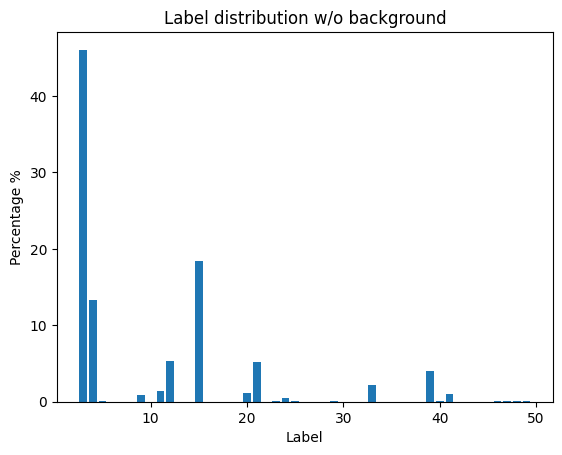

3 -> 46.0432249708005 %
15 -> 18.395875286613627 %
4 -> 13.241420499021064 %
12 -> 5.350512787597371 %
21 -> 5.150924585676436 %
39 -> 3.965289128545621 %
33 -> 2.177971209619009 %
11 -> 1.343062636310564 %
20 -> 1.1226046692159894 %
41 -> 0.9839927110110204 %
9 -> 0.8874123324257079 %
24 -> 0.49468509026398044 %
25 -> 0.15517904260357043 %
40 -> 0.15278521353248314 %
5 -> 0.11429772444431294 %
46 -> 0.09502369883524367 %
48 -> 0.07329774498045497 %
49 -> 0.06869045488279794 %
29 -> 0.05042260273709396 %
23 -> 0.048612218147932464 %
47 -> 0.03408041375396402 %
30 -> 0.022396460230943376 %
13 -> 0.01443213135083966 %
32 -> 0.007269019215148304 %
31 -> 0.006537368184319217 %


In [115]:
labels_distribution[:,:,0] = 0 # neglecting background
percentage = 100*labels_distribution.sum(axis=(0,1))/labels_distribution.sum()
indices = percentage.nonzero()[0]
indices
plt.bar(indices,percentage[indices])
plt.xlabel("Label")
plt.ylabel("Percentage %")
plt.title('Label distribution w/o background')
plt.show()

sorted_labels = sorted(dict(zip(indices,percentage[indices])).items(),key=lambda x:x[1],reverse=True)
for label,percent in sorted_labels:
    print(label,"->",percent,"%")

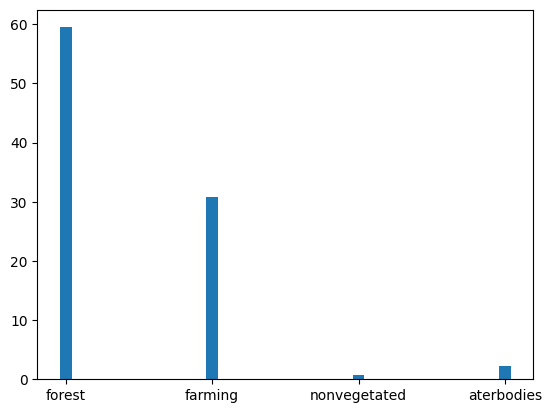

In [143]:
# label groups
forest = [1,3,4,5,49] 
farming = [14,15,18,9,21,19,41,39,20,40,36,46,47,48]
nonvegetated=[22,23,24,30,25]
waterbodies=[26,33,31]

forest_perc = sum([percent for label,percent in sorted_labels if label in forest])
farming_perc = sum([percent for label,percent in sorted_labels if label in farming])
nonvegetated_perc = sum([percent for label,percent in sorted_labels if label in nonvegetated])
waterbodies_perc = sum([percent for label,percent in sorted_labels if label in waterbodies])


plt.bar([10,20,30,40],[forest_perc,farming_perc,nonvegetated_perc,waterbodies_perc],tick_label=['forest','farming','nonvegetated','waterbodies'])
plt.show()


In [128]:
# Center of the map Longitude,latitude
print(data.lnglat())

(-53.9793611808642, -13.43982971300478)


In [136]:
#dir(data)

In [8]:
data.close()

# Dataset creation

In [2]:
# getting block with labels of interest
forest = [3,4,5,49] 
natural_nonforest = [11,12,32,29,13]
farming = [15,9,21,41,39,20,40,46,47,48]
nonvegetated=[23,24,30,25]
waterbodies=[33,31]


all_labels = forest + farming + nonvegetated + waterbodies + natural_nonforest
labels_mapping = {'forest':forest,'farming':farming,'nonvegetated':nonvegetated,'waterbodies':waterbodies,'natural-nonforest':natural_nonforest}

## Split method: based on 5km*5km blocks
each block has 5 tiles of size 1km*1km

### Visualizing labelling scheme

In [41]:
tilesize=38
x = np.arange(0,5000,tilesize)
y = np.arange(0,5000,tilesize)
xv,yv = np.meshgrid(x,y,indexing='xy')

df_dummy = pd.DataFrame(columns=['block_x','block_y'])
df_dummy.block_x = xv.ravel()
df_dummy.block_y = yv.ravel()

In [42]:
schema = np.array([[0,2,1,0,0],
                   [2,1,0,0,0],
                   [1,0,0,0,2],
                   [0,0,0,2,1]])

vals,counts = np.unique(schema,return_counts=True)
vals,counts/(schema.shape[0]*schema.shape[1])

(array([0, 1, 2]), array([0.6, 0.2, 0.2]))

In [43]:
df_dummy = train_test_split(df_dummy,
                            num_tiles_per_block=5,
                            labeling_schema=schema)

100%|██████████| 17424/17424 [00:00<00:00, 24513.25it/s]


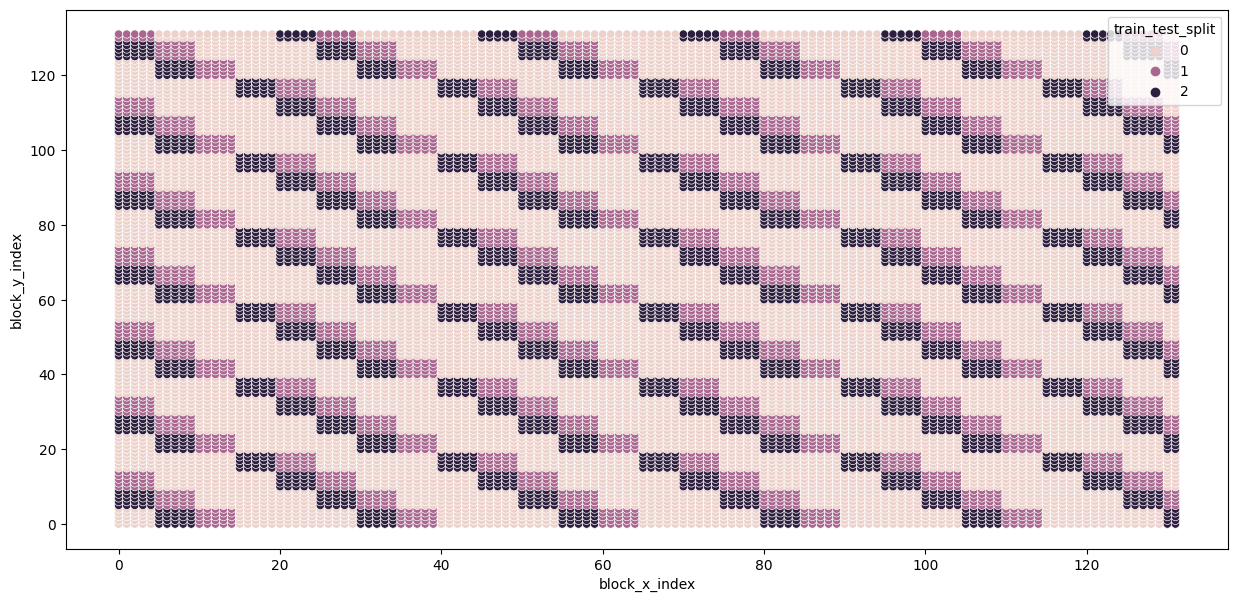

In [44]:
fig,axs = plt.subplots(1,1,figsize=(15,7))
sns.scatterplot(data=df_dummy,x='block_x_index',y='block_y_index',hue='train_test_split',ax=axs)
plt.show()

### Labelling scheme 1
Labeling_schema = np.array([[0,2,1,0],
                            [2,1,0,2],
                            [1,0,2,1],
                            [0,2,1,0]])

In [8]:
year=2018
labels_path = Path(f"../data/brasil_coverage_{year}.tif")
df_labelsDist2 = pd.read_csv(f'../data/{os.path.basename(labels_path).split(sep=".")[0]}_labelDist_2.csv')
df_labelsDist2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4783081 entries, 0 to 4783080
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   block_x_index     int64  
 1   block_y_index     int64  
 2   block_x           int64  
 3   block_y           int64  
 4   xmin              float64
 5   ymin              float64
 6   xmax              float64
 7   ymax              float64
 8   tile_label        int64  
 9   train_test_split  int64  
dtypes: float64(4), int64(6)
memory usage: 364.9 MB


In [9]:
schema = np.array([[0,2,1,0],
                   [2,1,0,2],
                   [1,0,2,1],
                   [0,2,1,0]])

vals,counts = np.unique(schema,return_counts=True)
vals,counts/(schema.shape[0]*schema.shape[1])

(array([0, 1, 2]), array([0.375 , 0.3125, 0.3125]))

In [10]:
df_labelsDist2 = train_test_split(df_labelsDist2,
                                  num_tiles_per_block=5,
                                  splits_by_block=None,
                                  labeling_schema=schema)

100%|██████████| 4783081/4783081 [03:18<00:00, 24053.36it/s]


In [11]:
df_labelsDist2.head(10)

block_x_index  block_y_index  block_x  block_y       xmin      ymin  \
0           1343              0    54416     9804 -60.232579  5.259726   
1           1344              0    54454     9804 -60.222338  5.259726   
2           1345              0    54492     9804 -60.212097  5.259726   
3           1346              0    54530     9804 -60.201856  5.259726   
4           1341              1    54340     9842 -60.253060  5.249485   
5           1342              1    54378     9842 -60.242820  5.249485   
6           1343              1    54416     9842 -60.232579  5.249485   
7           1344              1    54454     9842 -60.222338  5.249485   
8           1345              1    54492     9842 -60.212097  5.249485   
9           1346              1    54530     9842 -60.201856  5.249485   

        xmax      ymax  tile_label  train_test_split  
0 -60.222338  5.269967           0                 0  
1 -60.212097  5.269967           3                 0  
2 -60.201856  5.269967           3                 2  
3 -60.191616  5.269967           0                 2  
4 -60.242820  5.259726           0                 0  
5 -60.232579  5.259726           3                 0  
6 -60.222338  5.259726           3                 0  
7 -60.212097  5.259726           3                 0  
8 -60.201856  5.259726           3                 2  
9 -60.191616  5.259726           3                 2

<Axes: xlabel='block_x_index', ylabel='block_y_index'>

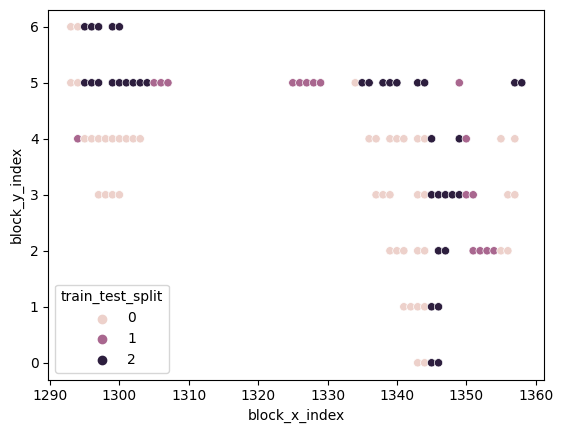

In [12]:
sns.scatterplot(data=df_labelsDist2.head(100),x='block_x_index',y='block_y_index',hue='train_test_split',)

In [36]:
#df_labelsDist2.groupby(by=['tile_label','train_test_split']).count()[['xmin']]

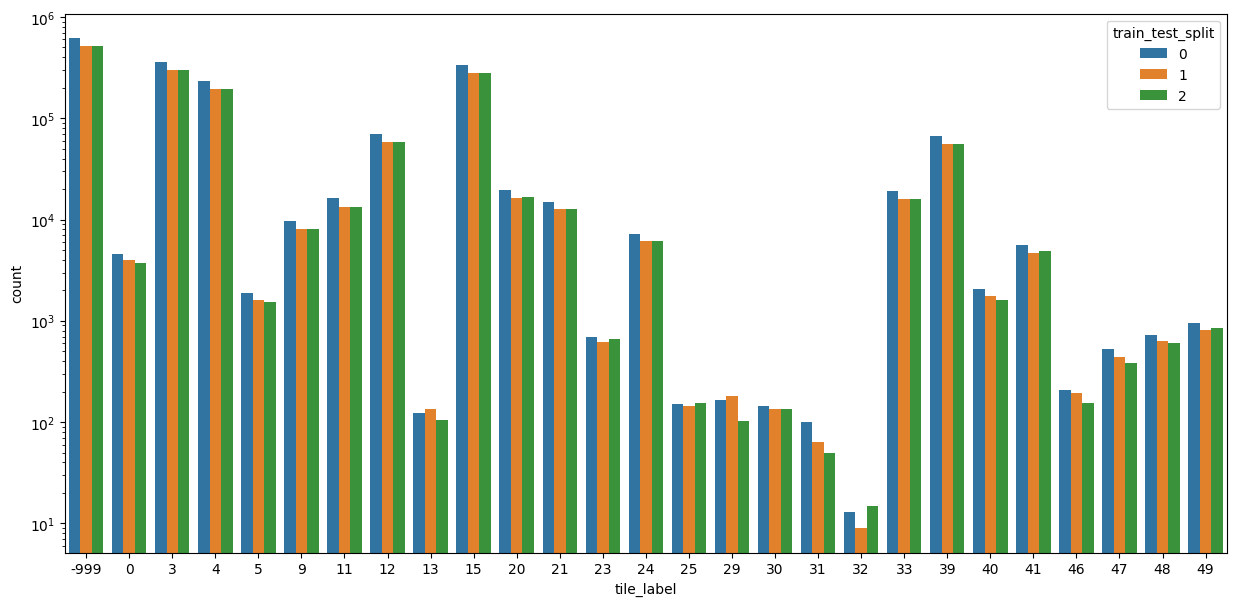

In [39]:
fig,axs = plt.subplots(1,1,figsize=(15,7))
plt.yscale('log')
sns.countplot(data=df_labelsDist2,x='tile_label',hue='train_test_split',ax=axs)
plt.show()

In [40]:
#-- check if all labels appear
intersection = list(set(df_labelsDist2.tile_label.unique().tolist()) & set(all_labels))
missing_labels = [a for a in all_labels if a not in intersection]
print('the missing labels are', missing_labels)

the missing labels are [1, 14, 18, 19, 36, 22, 26]


In [47]:

for label_name,value in labels_mapping.items(): 
    for missed in missing_labels:
        if missed in value:
            print(label_name,missed)

forest 1
farming 14
farming 18
farming 19
farming 36
nonvegetated 22
waterbodies 26


### Labelling scheme 2:


In [27]:
year=2018
labels_path = Path(f"../data/brasil_coverage_{year}.tif")
df_labelsDist2 = pd.read_csv(f'../data/{os.path.basename(labels_path).split(sep=".")[0]}_labelDist_2.csv')
df_labelsDist2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4783081 entries, 0 to 4783080
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   block_x_index     int64  
 1   block_y_index     int64  
 2   block_x           int64  
 3   block_y           int64  
 4   xmin              float64
 5   ymin              float64
 6   xmax              float64
 7   ymax              float64
 8   tile_label        int64  
 9   train_test_split  int64  
dtypes: float64(4), int64(6)
memory usage: 364.9 MB


In [28]:
schema = np.array([[0,2,1,0,0],
                   [2,1,0,0,0],
                   [1,0,0,0,2],
                   [0,0,0,2,1]])

vals,counts = np.unique(schema,return_counts=True)
vals,counts/(schema.shape[0]*schema.shape[1])

(array([0, 1, 2]), array([0.6, 0.2, 0.2]))

In [29]:
df_labelsDist2 = train_test_split(df_labelsDist2,
                                num_tiles_per_block=5,
                                labeling_schema=schema)

100%|██████████| 4783081/4783081 [03:18<00:00, 24124.18it/s]


In [30]:
df_labelsDist2.head(10)

block_x_index  block_y_index  block_x  block_y       xmin      ymin  \
0           1343              0    54416     9804 -60.232579  5.259726   
1           1344              0    54454     9804 -60.222338  5.259726   
2           1345              0    54492     9804 -60.212097  5.259726   
3           1346              0    54530     9804 -60.201856  5.259726   
4           1341              1    54340     9842 -60.253060  5.249485   
5           1342              1    54378     9842 -60.242820  5.249485   
6           1343              1    54416     9842 -60.232579  5.249485   
7           1344              1    54454     9842 -60.222338  5.249485   
8           1345              1    54492     9842 -60.212097  5.249485   
9           1346              1    54530     9842 -60.201856  5.249485   

        xmax      ymax  tile_label  train_test_split  
0 -60.222338  5.269967           0                 0  
1 -60.212097  5.269967           3                 0  
2 -60.201856  5.269967           3                 0  
3 -60.191616  5.269967           0                 0  
4 -60.242820  5.259726           0                 0  
5 -60.232579  5.259726           3                 0  
6 -60.222338  5.259726           3                 0  
7 -60.212097  5.259726           3                 0  
8 -60.201856  5.259726           3                 0  
9 -60.191616  5.259726           3                 0

<Axes: xlabel='block_x_index', ylabel='block_y_index'>

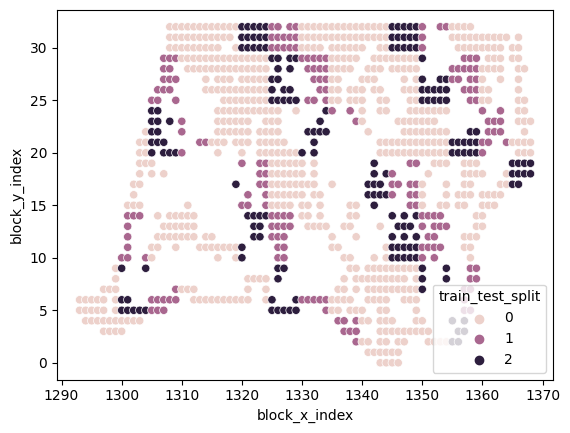

In [36]:
sns.scatterplot(data=df_labelsDist2.head(1000),x='block_x_index',y='block_y_index',hue='train_test_split') # sampling

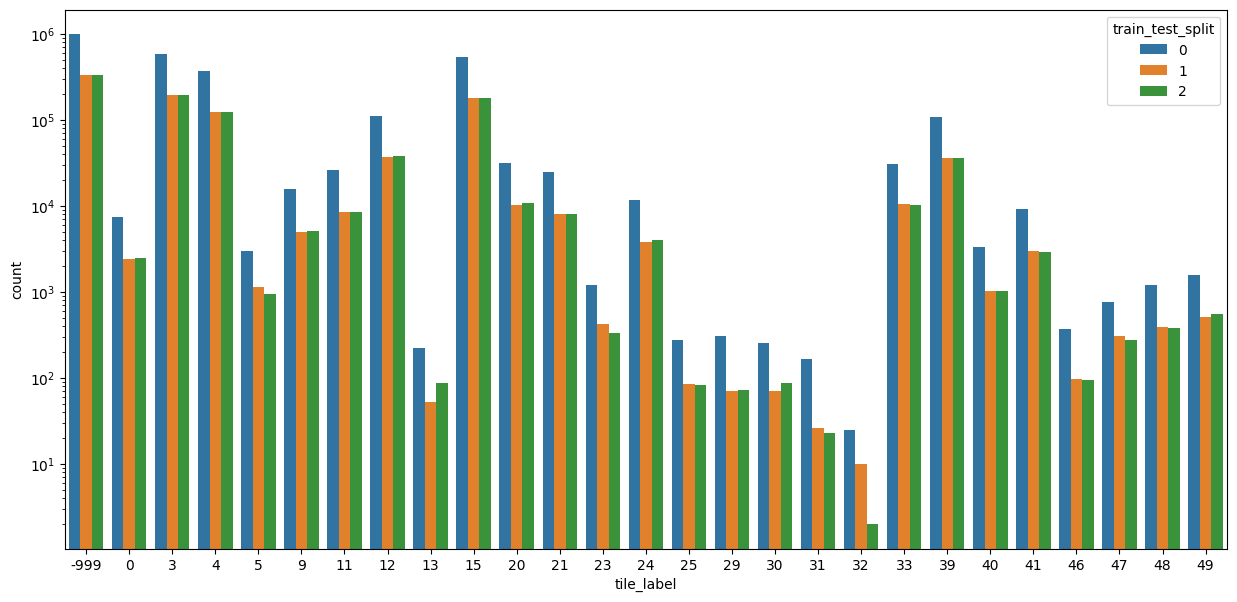

In [37]:
fig,axs = plt.subplots(1,1,figsize=(15,7))
plt.yscale('log')
sns.countplot(data=df_labelsDist2,x='tile_label',hue='train_test_split',ax=axs)
plt.show()

In [38]:
#-- check if all labels appear
intersection = list(set(df_labelsDist2.tile_label.unique().tolist()) & set(all_labels))
missing_labels = [a for a in all_labels if a not in intersection]
print('the missing labels are', missing_labels)

the missing labels are []


## Sampling of tiles

### Explaining sampling method
The idea it to give a probability dependong on the position of the tile. We want to avoid picking tiles close to the 5km*5km boundary.

In [8]:
tilesize=38
x = np.arange(0,5000,tilesize)
y = np.arange(0,5000,tilesize)
xv,yv = np.meshgrid(x,y,indexing='xy')

df_dummy = pd.DataFrame(columns=['block_x','block_y'])
df_dummy.block_x = xv.ravel()
df_dummy.block_y = yv.ravel()

In [9]:
schema = np.array([[0,2,1,0,0],
                   [2,1,0,0,0],
                   [1,0,0,0,2],
                   [0,0,0,2,1]])

vals,counts = np.unique(schema,return_counts=True)
print(vals,counts/(schema.shape[0]*schema.shape[1]))

df_dummy = train_test_split(df_dummy,
                            num_tiles_per_block=5,
                            labeling_schema=schema)

[0 1 2] [0.6 0.2 0.2]


100%|██████████| 17424/17424 [00:00<00:00, 23675.73it/s]


In [10]:
#-- get split
df_dummy['sampling_weight'] = get_samplingweight(df_dummy.block_x_index,df_dummy.block_y_index,labelling_schema=schema)
df_dummy.sample(5)


block_x_index  block_y_index  block_x  block_y  train_test_split  \
15450              6            117      228     4446                 0   
569               41              4     1558      152                 0   
16167             63            122     2394     4636                 1   
5208              60             39     2280     1482                 0   
6413              77             48     2926     1824                 2   

       sampling_weight  
15450         0.198660  
569           0.104670  
16167         0.346779  
5208          0.142582  
6413          0.174304

In [11]:
df_dummy.sample(10,weights=None)

block_x_index  block_y_index  block_x  block_y  train_test_split  \
4865             113             36     4294     1368                 0   
9103             127             68     4826     2584                 2   
1103              47              8     1786      304                 0   
14045             53            106     2014     4028                 2   
2332              88             17     3344      646                 0   
12698             26             96      988     3648                 0   
12154             10             92      380     3496                 0   
2928              24             22      912      836                 0   
3351              51             25     1938      950                 2   
1778              62             13     2356      494                 0   

       sampling_weight  
4865          0.174304  
9103          0.174304  
1103          0.174304  
14045         0.346779  
2332          0.268293  
12698         0.104670  
12154         0.048592  
2928          0.277146  
3351          0.198660  
1778          0.268293

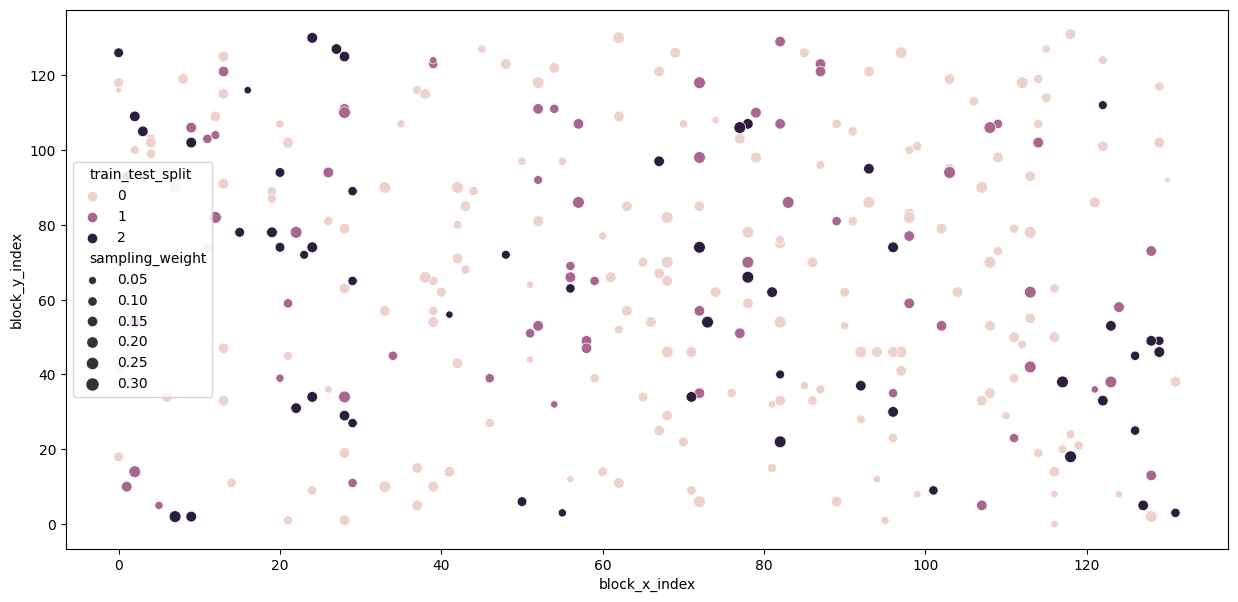

In [13]:
fig,axs = plt.subplots(1,1,figsize=(15,7))
sns.scatterplot(data=df_dummy.sample(300,weights='sampling_weight'),x='block_x_index',y='block_y_index',hue='train_test_split',size='sampling_weight',ax=axs)
plt.show()

### Visualizing the label distribution of sampled data

In [2]:
# getting block with labels of interest
forest = [3,4,5,49] 
natural_nonforest = [11,12,32,29,13]
farming = [15,9,21,41,39,20,40,46,47,48]
nonvegetated=[23,24,30,25]
waterbodies=[33,31]


all_labels = forest + farming + nonvegetated + waterbodies + natural_nonforest
labels_mapping = {'forest':forest,'farming':farming,'nonvegetated':nonvegetated,'waterbodies':waterbodies,'natural-nonforest':natural_nonforest}

In [3]:
year=2018
labels_path = Path(f"../data/brasil_coverage_{year}.tif")
df_labelsDist2 = pd.read_csv(f'../data/{os.path.basename(labels_path).split(sep=".")[0]}_labelDist_2.csv')

schema = np.array([[0,2,1,0,0],
                   [2,1,0,0,0],
                   [1,0,0,0,2],
                   [0,0,0,2,1]])


df_labelsDist2 = train_test_split(df_labelsDist2,
                                num_tiles_per_block=5,
                                labeling_schema=schema)

#-- check if all labels appear
intersection = list(set(df_labelsDist2.tile_label.unique().tolist()) & set(all_labels))
missing_labels = [a for a in all_labels if a not in intersection]
print('the missing labels are', missing_labels)


100%|██████████| 4783081/4783081 [03:24<00:00, 23366.23it/s]


the missing labels are []


In [4]:
#-- Get target distribution
target_distribution = get_targetdistribution(df_labelsDist2,min_examples=150,ratio=3)
#target_distribution

Sampled data splits: 
                   to_sample  percentage
train_test_split                       
0                      9725   60.830675
1                      3112   19.465816
2                      3150   19.703509


Labelling schema: 
 [[0 2 1 0 0]
 [2 1 0 0 0]
 [1 0 0 0 2]
 [0 0 0 2 1]]
selecting tiles:


100%|██████████| 75/75 [00:03<00:00, 19.10it/s]


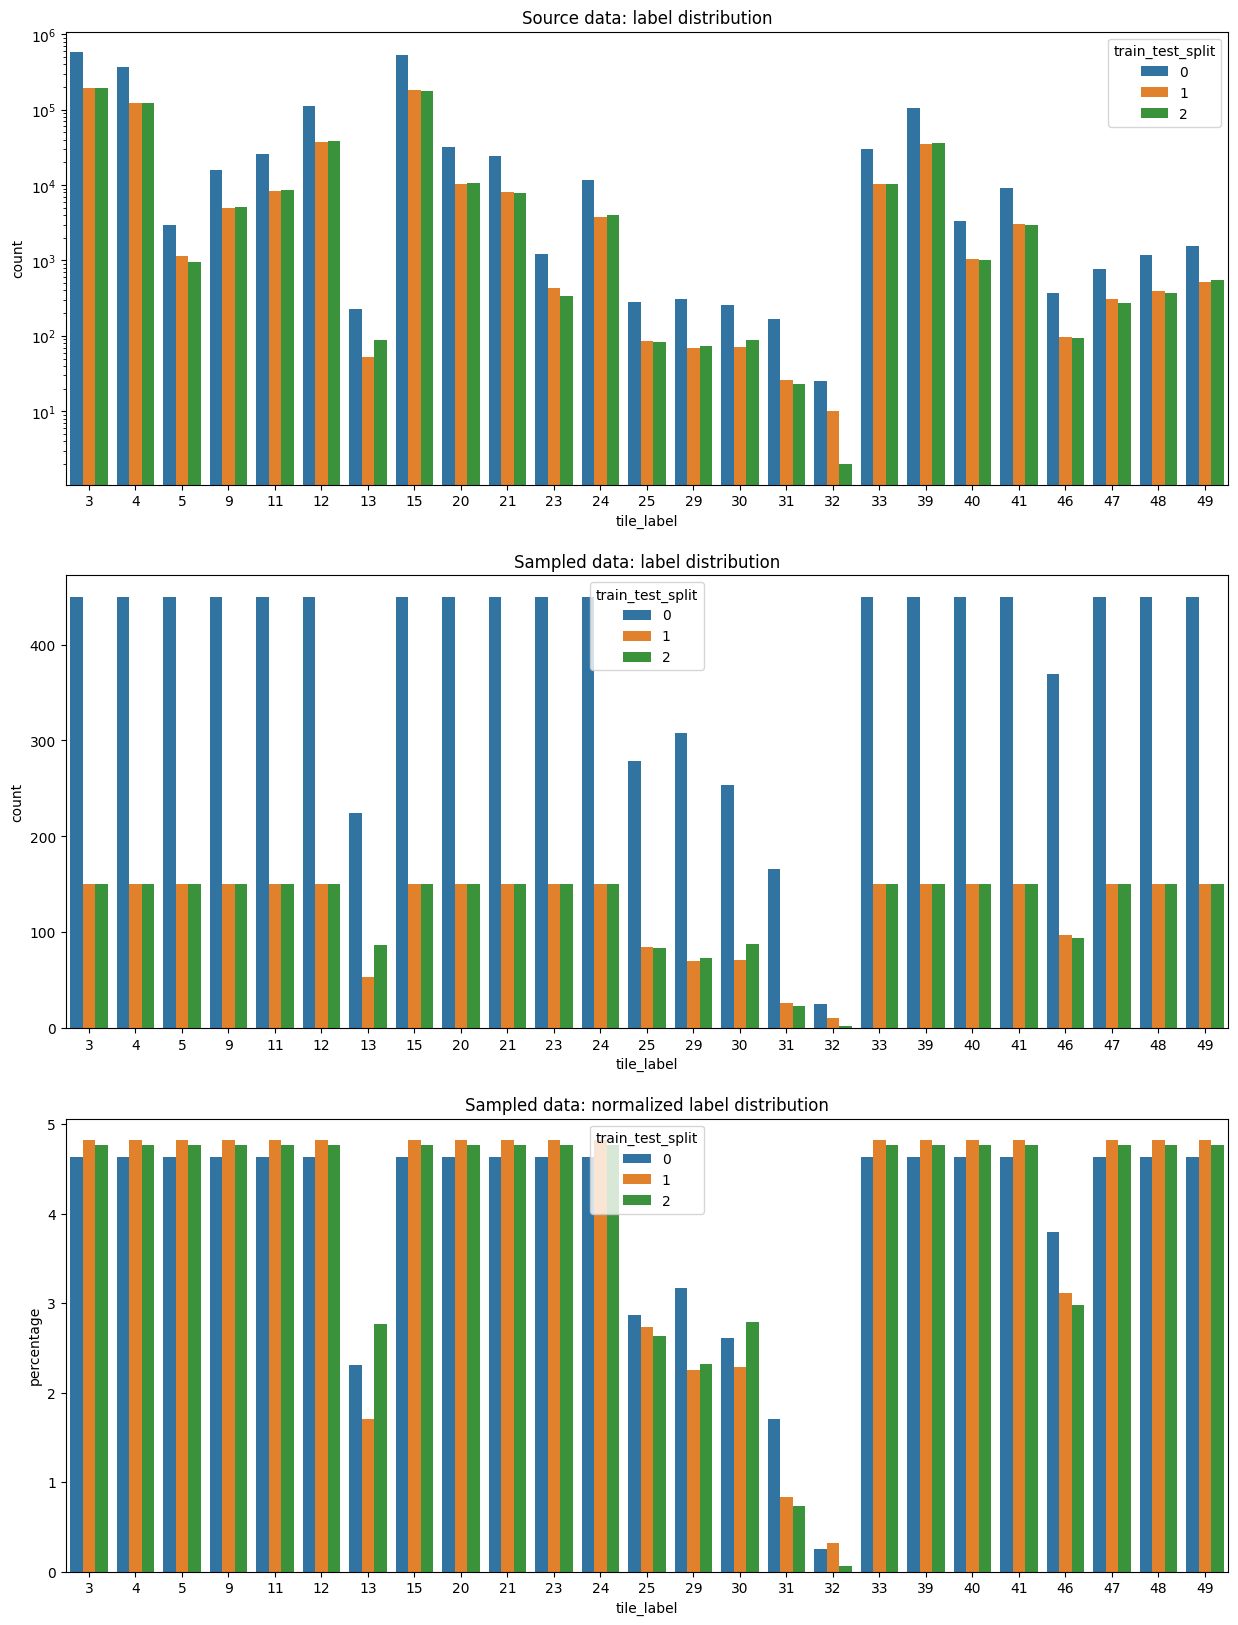

In [5]:
df_sample = get_sample(target_distribution,df_labelsDist2,schema)

In [6]:
df_sample['x_center'] = 0.5*(df_sample.xmin + df_sample.xmax)
df_sample['y_center'] = 0.5*(df_sample.ymin + df_sample.ymax)

df_sample.head()

block_x_index  block_y_index  block_x  block_y       xmin      ymin  \
319            1327             14    53808    10336 -60.396431  5.116355   
1261           1302             38    52858    11248 -60.652451  4.870576   
1462           1326             42    53770    11400 -60.406672  4.829612   
1472           1349             42    54644    11400 -60.171134  4.829612   
1826           1331             52    53960    11780 -60.355468  4.727205   

           xmax      ymax  tile_label  train_test_split  sampling_weight  \
319  -60.386191  5.126595          12                 1         0.346779   
1261 -60.642211  4.880816          12                 0         0.346779   
1462 -60.396431  4.839853           3                 0         0.277146   
1472 -60.160893  4.839853          12                 0         0.277146   
1826 -60.345228  4.737445          12                 0         0.104670   

      selected   x_center  y_center  
319       True -60.391311  5.121475  
1261      True -60.647331  4.875696  
1462      True -60.401552  4.834733  
1472      True -60.166014  4.834733  
1826      True -60.350348  4.732325

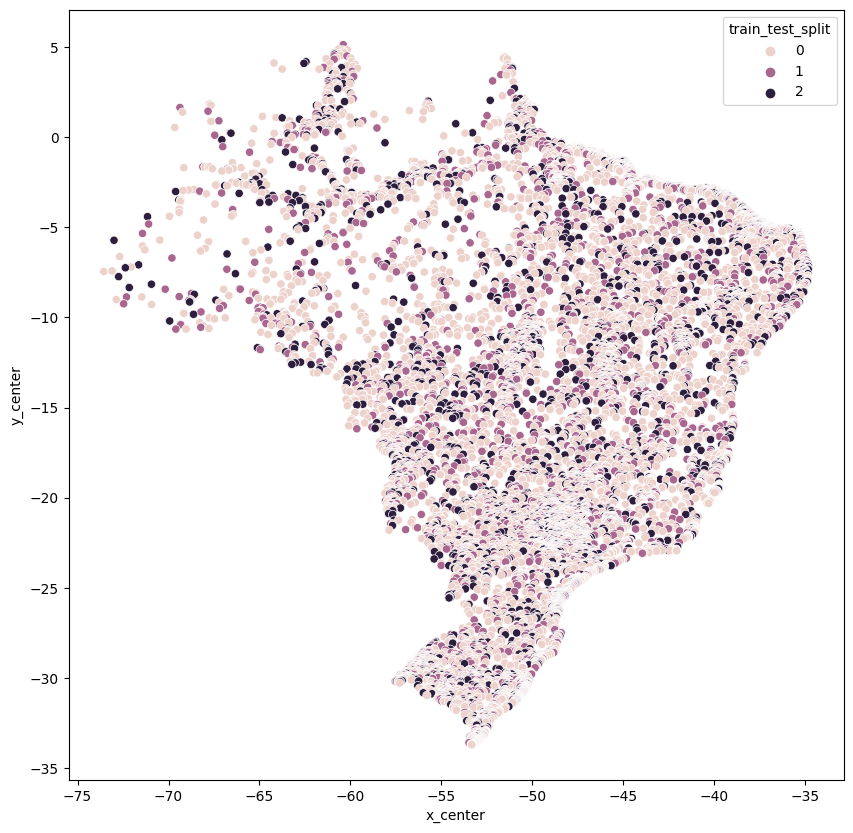

In [7]:
fig,axs = plt.subplots(1,1,figsize=(10,10))

sns.scatterplot(data=df_sample,x='x_center',y='y_center',hue='train_test_split',markers='+',ax=axs)
plt.show()

In [8]:
df_sample['geometry'] = df_sample.apply(lambda row: Point(row.x_center, row.y_center), axis=1)

df_sample = df_sample.reset_index().rename(columns={'index':'sampleid'})
df_sample.head()

sampleid  block_x_index  block_y_index  block_x  block_y       xmin  \
0       319           1327             14    53808    10336 -60.396431   
1      1261           1302             38    52858    11248 -60.652451   
2      1462           1326             42    53770    11400 -60.406672   
3      1472           1349             42    54644    11400 -60.171134   
4      1826           1331             52    53960    11780 -60.355468   

       ymin       xmax      ymax  tile_label  train_test_split  \
0  5.116355 -60.386191  5.126595          12                 1   
1  4.870576 -60.642211  4.880816          12                 0   
2  4.829612 -60.396431  4.839853           3                 0   
3  4.829612 -60.160893  4.839853          12                 0   
4  4.727205 -60.345228  4.737445          12                 0   

   sampling_weight  selected   x_center  y_center  \
0         0.346779      True -60.391311  5.121475   
1         0.346779      True -60.647331  4.875696   
2         0.277146      True -60.401552  4.834733   
3         0.277146      True -60.166014  4.834733   
4         0.104670      True -60.350348  4.732325   

                                        geometry  
0  POINT (-60.391311100088316 5.121475097822216)  
1  POINT (-60.647330956062376 4.875696036087115)  
2  POINT (-60.40155189432727 4.8347328591312655)  
3  POINT (-60.16601362683113 4.8347328591312655)  
4   POINT (-60.35034792313246 4.732324916741639)

In [9]:
#-- save file as csv
save_path = f'../data/{os.path.basename(labels_path).split(sep=".")[0]}_sample.csv'
df_sample.to_csv(save_path,index=False)

In [10]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15987 entries, 0 to 15986
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sampleid          15987 non-null  int64  
 1   block_x_index     15987 non-null  int64  
 2   block_y_index     15987 non-null  int64  
 3   block_x           15987 non-null  int64  
 4   block_y           15987 non-null  int64  
 5   xmin              15987 non-null  float64
 6   ymin              15987 non-null  float64
 7   xmax              15987 non-null  float64
 8   ymax              15987 non-null  float64
 9   tile_label        15987 non-null  int64  
 10  train_test_split  15987 non-null  int64  
 11  sampling_weight   15987 non-null  float64
 12  selected          15987 non-null  bool   
 13  x_center          15987 non-null  float64
 14  y_center          15987 non-null  float64
 15  geometry          15987 non-null  object 
dtypes: bool(1), float64(7), int64(7), object

# Visualize downloaded data

In [8]:
from skimage.io import imread

In [3]:
file = imread("../data/images-2018/1698516/20180428T133229_20180428T133223_T23LKK_opaque_clouds_0_cirrus_0_CLOUD_PERC_0.tif")

In [6]:
file.shape

(256, 256, 5)

In [7]:
np.max(file,axis=(0,1)),np.min(file,axis=(0,1))

(array([1219, 1210, 1536, 3299,    0], dtype=uint16),
 array([0, 0, 0, 0, 0], dtype=uint16))

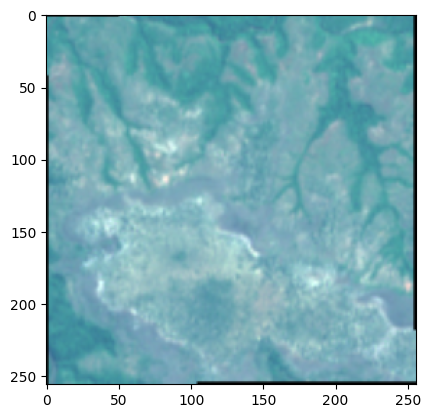

In [12]:
image = file[:,:,:-2]/np.max(file[:,:,:-2],axis=(0,1))

plt.imshow(image[:,:,[2,1,0]]) # transposing 2>R,1>G,0>B

In [6]:
# visualizingimages from dataloader
config = Args()
config.apply_augmentation = False
config.batch_size = 1 # entire training set
config.in_channels = 4

datamodule = Datamodule(config)
datamodule.setup(stage='fit')

Size of train dataset :  9700
Size of validation dataset :  3102
Shape of data sample :  torch.Size([4, 256, 256])


In [4]:
mean = torch.Tensor(config.traindata_mean_4channels)
std = torch.Tensor(config.traindata_std_4channels)
# std_inv = 1 / (std + 1e-7)
# unnormalize = torchvision.transforms.Normalize(-mean * std_inv, std_inv)
all_labels = get_dataset_labels(config.label_hierarchy)
indices_level1,indices_level2,indices_level3,indices_level4,indices_leaf = get_level_indices(config.label_hierarchy)



In [17]:
#Saving images of each leaf label
def save_img(images,labels):
    i=0
    img = images[i,:-1,:,:].transpose(0,1).transpose(2,1).numpy()
    img = img/ img.max(axis=(0,1))
    label = (labels[i].numpy()*all_labels)[indices_leaf]
    label = label[label != 0][0]
    imsave(f'example_img_class_{label}.png',img)
    return None

for label in all_labels[indices_leaf]:
    loader = iter(datamodule.val_dataloader())
    for images, labels in loader:
        l = (labels[0].numpy()*all_labels)[indices_leaf]
        #print(i,l[l!=0])
        if label in l[l != 0]:
            save_img(images,labels)
            break

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

39


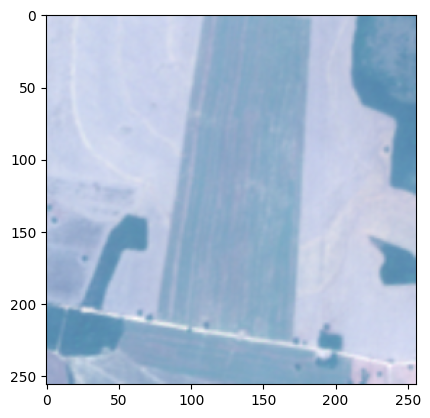

In [12]:
i=0
img = images[i,:-1,:,:].transpose(0,1).transpose(2,1).numpy()
img = img/ img.max(axis=(0,1))

label = (labels[i].numpy()*all_labels)[indices_leaf]
label = label[label != 0][0]

print(label)

plt.imshow(img)
plt.show()

In [13]:
imsave(f'example_img_class_{label}.png',img)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [60]:
from torchvision.utils import make_grid

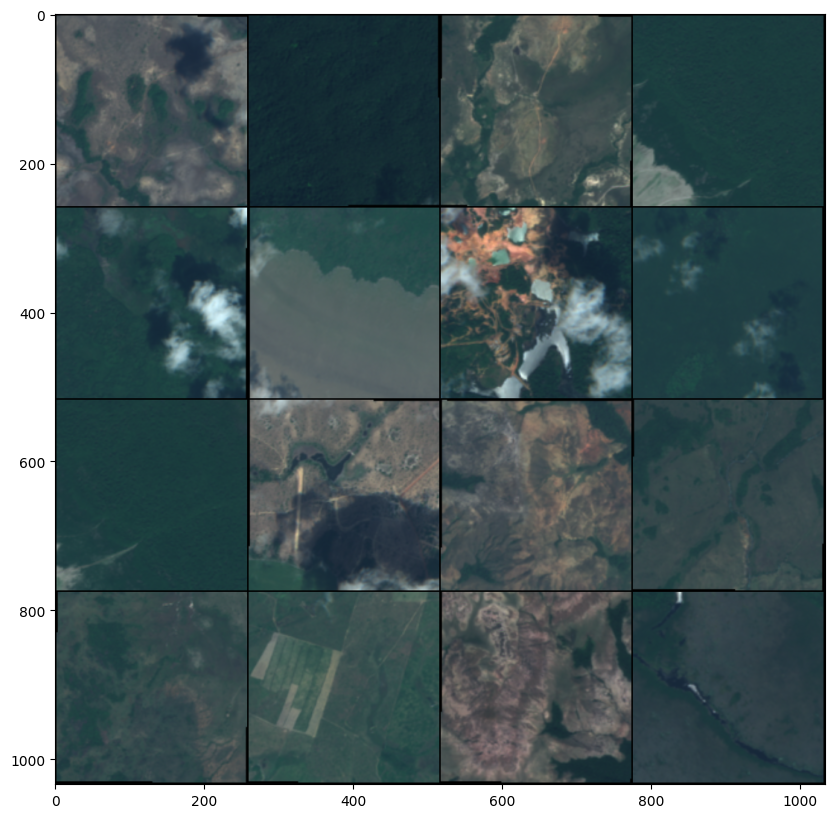

In [89]:
fig,axs = plt.subplots(1,1,figsize=(10,10))

imgs = images[np.random.choice(64,16,replace=False),:-1,:,:].numpy()
imgs = imgs/ imgs.max(axis=(0,2,3))[None,:,None,None]
grid = make_grid(torch.from_numpy(imgs),nrow=4)
grid = grid.transpose(0,1).transpose(1,2).numpy()

plt.imshow(grid)

In [78]:
grid.shape

(260, 2066, 3)

# Debugging Dataloader & Neural net

In [2]:
config = Args()
config.apply_augmentation = False
config.batch_size = 32 # entire training set
config.in_channels = 4

In [46]:
labels_names = pd.read_csv(config.label_names,sep=';').set_index('label',inplace=False)
data_info = pd.read_csv(config.data_info,sep=',')


In [48]:
data_info.head(5)

sampleid  block_x_index  block_y_index  block_x  block_y       xmin  \
0       319           1327             14    53808    10336 -60.396431   
1      1261           1302             38    52858    11248 -60.652451   
2      1462           1326             42    53770    11400 -60.406672   
3      1472           1349             42    54644    11400 -60.171134   
4      1826           1331             52    53960    11780 -60.355468   

       ymin       xmax      ymax  tile_label  train_test_split  \
0  5.116355 -60.386191  5.126595          12                 1   
1  4.870576 -60.642211  4.880816          12                 0   
2  4.829612 -60.396431  4.839853           3                 0   
3  4.829612 -60.160893  4.839853          12                 0   
4  4.727205 -60.345228  4.737445          12                 0   

   sampling_weight  selected   x_center  y_center  \
0         0.346779      True -60.391311  5.121475   
1         0.346779      True -60.647331  4.875696   
2         0.277146      True -60.401552  4.834733   
3         0.277146      True -60.166014  4.834733   
4         0.104670      True -60.350348  4.732325   

                                        geometry  
0  POINT (-60.391311100088316 5.121475097822216)  
1  POINT (-60.647330956062376 4.875696036087115)  
2  POINT (-60.40155189432727 4.8347328591312655)  
3  POINT (-60.16601362683113 4.8347328591312655)  
4   POINT (-60.35034792313246 4.732324916741639)

In [104]:
# train-test splits
data_info.groupby(by=['train_test_split']).count()[['sampleid']]

sampleid
train_test_split          
0                     9725
1                     3112
2                     3150

In [47]:
labels_names.head(5)

name
label                            
1                          forest
3                forest formation
4               savanna formation
5                        mangrove
49     wooded sandbank vegetation

In [3]:
datamodule = Datamodule(config)
datamodule.setup(stage='fit')

Size of train dataset :  9725
Size of validation dataset :  3112
Shape of data sample :  torch.Size([4, 256, 256])


In [4]:
# Train data mean and std
images, labels = next(iter(datamodule.train_dataloader()))
mean, std = images.mean([0,2,3]), images.std([0,2,3])
mean,std

(tensor([  4.2111, 954.6794, 994.5911]),
 tensor([ 45.5396, 512.6230, 423.9982]))

In [4]:
train_loader = datamodule.train_dataloader()

images,labels = next(iter(train_loader))

images.shape,labels.shape

(torch.Size([32, 4, 256, 256]), torch.Size([32, 33]))

In [ ]:
model = Architecture(args=config)

In [ ]:
logits_labels, embeddings = model(images)
logits_labels.shape,embeddings.shape

In [107]:
#-- checking dataloader
count = 0
for img,target in train_loader:

    count = count + target.sum(dim=0)


In [42]:
count

tensor([1800,  450,  450,  450,  450, 1457,  450,  450,  224, 4419,  450, 3069,
        1800,    0,  450, 1433,  450,  450,  279,  616,  308,  254,  166,   25,
         450, 1269,    0,    0,    0,    0,    0,    0,  450])

In [44]:
all_labels = get_dataset_labels(config)
all_labels

array([ 1,  3,  4,  5,  9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 29, 30, 31, 32, 33, 36, 39, 40, 41, 46, 47, 48, 49])

In [49]:
for c,label in zip(count.numpy(),all_labels):
    print(c,'->',label,': ',labels_names.loc[label].to_list())

1800 -> 1 :  ['forest']
450 -> 3 :  ['forest formation']
450 -> 4 :  ['savanna formation']
450 -> 5 :  ['mangrove']
450 -> 9 :  ['forest plantation']
1457 -> 10 :  ['non forest natural formation']
450 -> 11 :  ['wetland']
450 -> 12 :  ['grassland']
224 -> 13 :  ['other non forest formations']
4419 -> 14 :  ['farming']
450 -> 15 :  ['pasture']
3069 -> 18 :  ['agriculture']
1800 -> 19 :  ['temporary crop']
0 -> 20 :  ['sugar cane']
450 -> 21 :  ['mosaic agriculture and pasture']
1433 -> 22 :  ['non vegetated area']
450 -> 23 :  ['beach dune and sand']
450 -> 24 :  ['urban area']
279 -> 25 :  ['other vegetated areas']
616 -> 26 :  ['water']
308 -> 29 :  ['rocky outcrop']
254 -> 30 :  ['mining']
166 -> 31 :  ['aquaculture']
25 -> 32 :  ['salt flat']
450 -> 33 :  ['river lake and ocean']
1269 -> 36 :  ['perennial crops']
0 -> 39 :  ['soy bean']
0 -> 40 :  ['rice']
0 -> 41 :  ['other temporary crops']
0 -> 46 :  ['coffee']
0 -> 47 :  ['citrus']
0 -> 48 :  ['other perennial crops']
450 -> 49 

In [5]:
for ind,batch in tqdm(datamodule.val_data):
    _ = batch

for ind,batch in tqdm(datamodule.train_data):
    _ = batch
    

100%|██████████| 9725/9725 [02:33<00:00, 63.37it/s] 


In [4]:
train_set = Mydataset(mode=0,args=config)

In [59]:
train_set.images[0]

[PosixPath('../data/images-2018/1261/20180106T142849_20180106T142845_T20NQL_opaque_clouds_0_cirrus_0_CLOUD_PERC_2.24.tif')]

In [55]:
for img in train_set.images:
    if len(img) == 0:
        print(img)

In [5]:
train_set.label_hierarchy

level4  level3  level2  level1
leaf                                
41        41      19      18      14
39        39      19      18      14
20        20      19      18      14
40        40      19      18      14
46        46      36      18      14
47        47      36      18      14
48        48      36      18      14
3          3       3       3       1
4          4       4       4       1
5          5       5       5       1
49        49      49      49       1
11        11      11      11      10
12        12      12      12      10
32        32      32      32      10
29        29      29      29      10
13        13      13      13      10
15        15      15      15      14
9          9       9       9      14
21        21      21      21      14
23        23      23      23      22
24        24      24      24      22
30        30      30      30      22
25        25      25      25      22
33        33      33      33      26
31        31      31      31      26

In [101]:
get_label(all_labels,20,train_set.label_hierarchy)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [102]:
all_labels

array([ 1,  3,  4,  5,  9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 29, 30, 31, 32, 33, 36, 39, 40, 41, 46, 47, 48, 49])

In [103]:

for l in train_set.label_hierarchy.index:
  
  label = get_label(train_set.all_labels,
                  l,
                train_set.label_hierarchy)
  reverse_encoding = np.unique(reverse_label_encoding(onehot_label=label,all_labels=train_set.all_labels))

  print(f'Label: {l}\n',label,'\n',reverse_encoding,'\n\n')
    


Label: 41
 [0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0] 
 [ 0 14 18 19 41] 


Label: 39
 [0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0] 
 [ 0 14 18 19 39] 


Label: 20
 [0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 [ 0 14 18 19 20] 


Label: 40
 [0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] 
 [ 0 14 18 19 40] 


Label: 46
 [0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0] 
 [ 0 14 18 36 46] 


Label: 47
 [0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0] 
 [ 0 14 18 36 47] 


Label: 48
 [0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0] 
 [ 0 14 18 36 48] 


Label: 3
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 [0 1 3] 


Label: 4
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 [0 1 4] 


Label: 5
 [1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 [0 1 5] 


Label: 49
 [1 0 0 0 

# Creating hierarchy aware losses

In [2]:
config = Args()
config.batch_size = 32
config.criterion = 'bce'
config.encoder_name = 'efficientnet-b3'
config.model_name = ''

model = Architecture(args=config)

datamodule = Datamodule(config)
datamodule.setup(stage='fit')

images,labels = next(iter(datamodule.train_dataloader()))
images.shape

Size of train dataset :  9725
Size of validation dataset :  3112
Shape of data sample :  torch.Size([4, 256, 256])


torch.Size([32, 4, 256, 256])

### Creating ancestry matrix

In [10]:
from utils import get_ancestry_matrix

In [11]:
A,indices = get_ancestry_matrix()

In [11]:
label_hierarchy_path=Path("../data/labelhierarchy.csv")

all_labels = get_dataset_labels(label_hierarchy_path)
label_hierarchy = pd.read_csv(label_hierarchy_path,sep=';')

label_hierarchy

leaf  level4  level3  level2  level1
0     41      41      19      18      14
1     39      39      19      18      14
2     20      20      19      18      14
3     40      40      19      18      14
4     46      46      36      18      14
5     47      47      36      18      14
6     48      48      36      18      14
7      3       3       3       3       1
8      4       4       4       4       1
9      5       5       5       5       1
10    49      49      49      49       1
11    11      11      11      11      10
12    12      12      12      12      10
13    32      32      32      32      10
14    29      29      29      29      10
15    13      13      13      13      10
16    15      15      15      15      14
17     9       9       9       9      14
18    21      21      21      21      14
19    23      23      23      23      22
20    24      24      24      24      22
21    30      30      30      30      22
22    25      25      25      25      22
23    33      33      33      33      26
24    31      31      31      31      26

In [14]:
A[:,indices[41]].flatten()*all_labels

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14.,  0., 18., 19.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., 41.,  0.,  0.,  0.,  0.])

(32,)

### Experimenting with hierarchy aware loss

In [5]:
logits = model(images)

In [8]:
loss = model.treeminloss(logits.sigmoid(),labels)
loss

tensor(1.0081, dtype=torch.float64, grad_fn=<AddBackward0>)

In [8]:
model.treeminloss.ancestryMatrix

tensor([[[1., 1., 1.,  ..., 0., 0., 1.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]])

In [28]:
mcm[0], labels[0]

(tensor([0.9369, 0.9369, 0.0060, 0.6055, 0.9252, 0.8006, 0.1241, 0.4081, 0.8006,
         0.9274, 0.3611, 0.9868, 0.9274, 0.9274, 0.6024, 0.9183, 0.5404, 0.3861,
         0.2366, 0.8244, 0.6204, 0.9183, 0.8244, 0.0805, 0.5966, 0.9317, 0.4097,
         0.8061, 0.0290, 0.8373, 0.4761, 0.8412, 0.0449], dtype=torch.float64,
        grad_fn=<SelectBackward0>),
 tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [30]:
all_labels*labels[0].numpy()

array([ 0,  0,  0,  0,  0, 10,  0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [32]:
np.nan * 0.0

nan

### Experimenting with tree triplet loss
Li et al., Deep Hierarchical Semantic Segmentation 

In [52]:
label_hierarchy_path=Path("../data/labelhierarchy.csv")

all_labels = get_dataset_labels(label_hierarchy_path)
label_hierarchy = pd.read_csv(label_hierarchy_path,sep=';')
# label_hierarchy.set_index('leaf',inplace=True)

In [30]:
# label_hierarchy

In [53]:
all_labels

array([ 1,  3,  4,  5,  9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 29, 30, 31, 32, 33, 36, 39, 40, 41, 46, 47, 48, 49])

In [54]:
graph,mapping_func = build_hierarchy_graph(label_hierarchy_path,
                              nodeLabel_as_target=True)

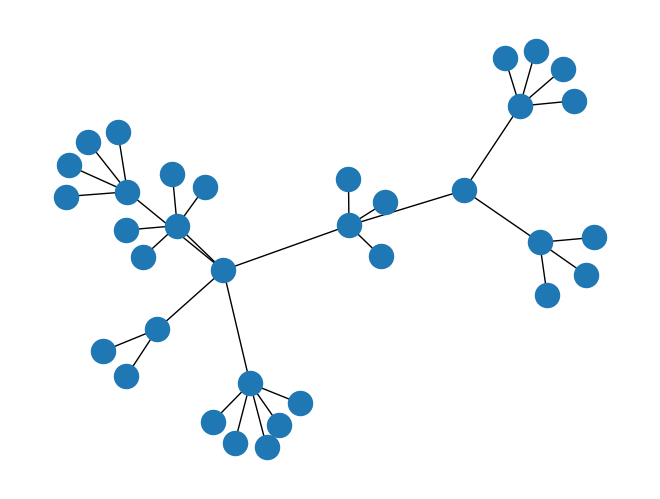

In [33]:
nx.draw(graph,with_labels=False)

In [57]:
tree_distance(graph,source=1,destination=3,mapping_func=mapping_func)

1

In [18]:
class TripletLoss(torch.nn.Module):

    def __init__(self, args:Args) -> None:
        super().__init__()

        self.args = args
        self.graph,_ = build_hierarchy_graph(args.label_hierarchy,
                                             nodeLabel_as_target=True)
        self.num_pairs = args.batch_size//2
        cosine = torch.nn.CosineSimilarity(dim=1)
        self.distance = lambda x,y : 0.5*(1.0 - cosine(x,y))
        self.device = 'cpu'
    
    def forward(self,x_embeddings:torch.Tensor,labels:torch.Tensor):

        positive_indices,negative_indices,is_valid,margins,flip_pos_neg = self.build_triplet(labels)
        num_samples = labels.shape[0]
        loss = 0
        num_valid = 0

        for i in range(num_samples):
            anchor   = x_embeddings[i,:].clone().view(1,-1)
            positive = x_embeddings.clone()
            negative = x_embeddings[torch.from_numpy(negative_indices[i]).to(self.device),:].clone()
            margin_i = torch.Tensor(margins[i]).view(1,-1).to(self.device)

            
            is_valid_i = torch.Tensor(is_valid[i]).view(1,-1).to(self.device)
            flip_pos_neg_i = torch.Tensor(flip_pos_neg[i]).view(1,-1).to(self.device)

            loss_i = self.distance(anchor,positive) - self.distance(anchor,negative)
            loss_i = loss_i*torch.float_power(-1.0,flip_pos_neg_i) + margin_i  
            loss_i = torch.nn.functional.relu(loss_i*(is_valid_i+flip_pos_neg_i)) 

            loss = loss + loss_i.sum()
            num_valid = num_valid + (is_valid_i+flip_pos_neg_i).sum().item()

        return loss/num_valid
    
    def build_triplet(self,labels:torch.Tensor):

        num_samples = labels.shape[0]
        choices = np.arange(num_samples)
        positive_indices = [choices for _ in range(num_samples)]
        negative_indices = [np.random.permutation(choices) for _ in range(num_samples)]

        is_valid,margins,flip_pos_neg = self.select_valid_samples(self.graph,
                                                                  labels,
                                                                  positive_indices,
                                                                  negative_indices)
        
        return positive_indices,negative_indices,is_valid,margins,flip_pos_neg 
    
    def select_valid_samples(self,graph,labels,positive_indices,negative_indices):
        
        # indicator variables
        is_valid = list()
        flip_pos_neg = list()
        # margins
        margins = list()
        #- mapping function
        func = lambda x: tuple(x.to('cpu').numpy().flatten().tolist())
        D = 1./4 # hierarchy tree height inverse

        for label_index in range(labels.shape[0]):
            is_valid_i = list()
            margins_i = list()
            flip_pos_neg_i = list()
            for pos,neg in (zip(positive_indices[label_index],
                                negative_indices[label_index])):
                #- get tree distance
                d_positive = tree_distance(graph,source=labels[label_index],destination=labels[pos],mapping_func=func)            
                d_negative = tree_distance(graph,source=labels[label_index],destination=labels[neg],mapping_func=func)
                #- get margin
                margin = 0.1 + 0.25*abs(d_negative-d_positive)*D
                margins_i.append(margin)
                #- get indicator variables
                is_valid_i.append((d_negative > d_positive)*1.0)
                flip_pos_neg_i.append((d_negative < d_positive)*1.0)

            margins.append(margins_i)
            is_valid.append(is_valid_i)
            flip_pos_neg.append(flip_pos_neg_i)
            
        return  is_valid, margins, flip_pos_neg

In [19]:
criterion = TripletLoss(args=config)

In [10]:
# positive_indices, negative_indices, is_valid, margins  = criterion.build_triplet(labels=labels,num_pairs=6)

In [15]:
logits_labels,embeddings = model(images)

In [20]:
loss = criterion(embeddings,labels)
#loss

tensor([ 1.3147e+00, -1.5925e+00, -1.2805e+00,  7.1774e-01, -4.4456e-01,
         1.8381e+00, -1.2844e-01, -3.8872e-01, -1.1379e+00,  7.1538e-01,
        -5.3492e-02, -8.3327e-01, -3.0889e-01, -1.9228e-02,  2.1242e+00,
        -7.2672e-01, -2.3214e+00, -2.2704e-01,  5.1381e-01, -1.4352e+00,
         2.6490e+00,  5.8170e-01,  1.0194e-02, -1.1934e+00, -1.4362e+00,
        -1.0129e+00,  7.1645e-01, -1.7953e+00, -1.2528e+00,  1.3727e+00,
         4.0522e-01, -1.1201e+00,  2.0107e+00,  4.7153e-01,  1.0047e+00,
        -1.2939e+00,  1.0714e+00, -8.6409e-01, -9.1139e-01,  1.0357e+00,
        -2.9660e-01,  5.6621e-02, -1.2361e+00,  2.1767e+00, -1.9775e-02,
        -1.9901e-01,  2.8747e+00,  1.6916e+00, -6.2451e-01, -5.3723e-01,
         2.7190e-01, -1.5490e-01,  1.7684e+00, -2.3494e-01,  1.4511e+00,
        -2.3008e+00,  1.9224e+00,  1.6311e+00,  1.4719e+00,  3.9246e-01,
         2.0969e-02,  2.3857e-01, -1.3080e-01, -1.2758e+00, -1.1631e+00,
         1.2673e+00, -2.2526e-01, -3.1192e+00,  1.4

Text(0.5, 1.0, 'Cosine annealing of Beta')

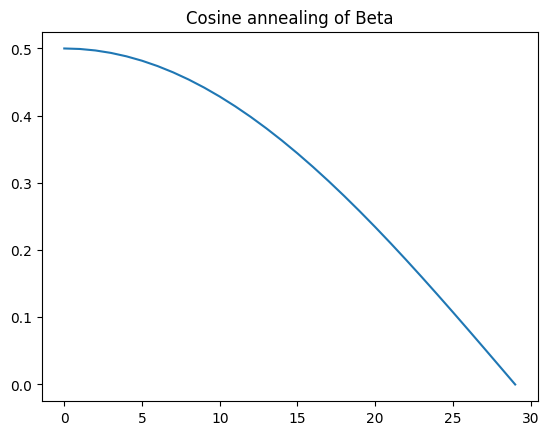

In [10]:
beta=0.5*np.cos(np.pi*0.5*np.arange(config.max_epochs)/(config.max_epochs-1))
plt.plot(beta)
plt.title('Cosine annealing of Beta')

In [76]:
a = torch.ones(15,requires_grad=True)
b = torch.ones(9,requires_grad=True)
x = torch.ones(6,requires_grad=True)
f = torch.zeros_like(a)
a_b = torch.cat((a,b))

f[:9] = b.clone()
f[9:] = x.clone()
c = (a*3).sum()
d = (b*5).sum()
# a_b = (a_b*2).sum()
f_ = (f*2).sum()

c.backward()
d.backward()
# a_b.backward()
f_.backward()


In [77]:
a.grad

tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [78]:
b.grad

tensor([7., 7., 7., 7., 7., 7., 7., 7., 7.])

In [79]:
f

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       grad_fn=<CopySlices>)

In [80]:
x.grad

tensor([2., 2., 2., 2., 2., 2.])

# Experimenting with custom architectures

In [29]:
config = Args()
config.batch_size = 8

datamodule = Datamodule(config)
datamodule.setup(stage='fit')

images,labels = next(iter(datamodule.train_dataloader()))
images.shape

Size of train dataset :  9725
Size of validation dataset :  3112
Shape of data sample :  torch.Size([4, 256, 256])


torch.Size([8, 4, 256, 256])

In [30]:
config.criterion = 'ce'
config.encoder_name = 'efficientnet-b3'
config.model_name = 'customArch'
config.customArch_strategy = 2
config.customArch_activation = 'identity'
config.customArch_useOtherLosses = False

In [31]:
# custom architectures for hierarchy
from models import Neuralnetwork
from copy import deepcopy
class CustomNetwork(torch.nn.Module):

    def __init__(self, args:Args) -> None:
        super().__init__()

        self.args = args
        model = Neuralnetwork(args=args)
        self.encoder = deepcopy(model.encoder)
        self.embeddings_size = model.embeddings_size
        self.device = 'cpu'   
        self.add_dummy = False # adds a dummy labels at level 3 & 4 for non existing labels at those levels

        # info on hierarchy
        self.all_labels = get_dataset_labels(args.label_hierarchy)
        self.indices_level1 ,self.indices_level2,self.indices_level3, self.indices_level4 = get_level_indices(args.label_hierarchy)
        self.level1_size = self.indices_level1.shape[0]
        self.level2_size = self.indices_level2.shape[0]
        self.level3_size = self.indices_level3.shape[0] + int(self.add_dummy)
        self.level4_size = self.indices_level4.shape[0] + int(self.add_dummy)

        # level logits
        self.x_1 = None
        self.x_2 = None
        self.x_3 = None
        self.x_4 = None
        
        self.pool_and_flatten = torch.nn.Sequential(torch.nn.AdaptiveAvgPool2d(1),torch.nn.Flatten())

        # activations
        if args.customArch_activation == 'RELU':
            self.activation = torch.nn.ReLU()
        elif args.customArch_activation == 'SELU':
            self.activation = torch.nn.SELU()
        elif args.customArch_activation == 'identity':
            self.activation = torch.nn.Identity()
        else:
            raise NotImplementedError

        # loss function
        if args.criterion == "ce" :
            self.criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        else:
            self.criterion = None
        
        # initilize Linear layers
        self.L1 = None
        self.L2 = None
        self.L3 = None
        self.L4 = None
        if args.customArch_strategy == 1:
            self.strategy_1()
        elif args.customArch_strategy == 2:
            self.strategy_2()
        else:
            raise NotImplementedError

        del model

    def forward(self,images):

        x_embeddings = self.encoder(images)
        x_embeddings = self.pool_and_flatten(x_embeddings[-1])

        if self.args.customArch_strategy == 1:
            self.x_1 = self.activation(self.L1(x_embeddings))
            self.x_2 = self.activation(self.L2(self.x_1))
            self.x_3 = self.activation(self.L3(self.x_2))
            self.x_4 = self.L4(self.x_3)
        
        elif self.args.customArch_strategy == 2:
            self.x_1 = self.activation(self.L1(x_embeddings))
            self.x_2 = self.activation(self.L2(torch.cat([x_embeddings,self.x_1],dim=1)))
            self.x_3 = self.activation(self.L3(torch.cat([x_embeddings,self.x_2],dim=1)))
            self.x_4 = self.L4(torch.cat([x_embeddings,self.x_3],dim=1))
        
        # get y_pred_logits
        y_pred_logits = torch.zeros((images.shape[0],self.all_labels.shape[0])).to(self.device)
        y_pred_logits[:,self.indices_level1] = self.x_1.clone()
        y_pred_logits[:,self.indices_level2] = self.x_2.clone()

        # if needed,discard dummy labels at position 0
        y_pred_logits[:,self.indices_level3] = self.x_3.clone()[:,int(self.add_dummy):]
        y_pred_logits[:,self.indices_level4] = self.x_4.clone()[:,int(self.add_dummy):]


        return y_pred_logits, x_embeddings
    
    def get_loss(self,labels:torch.Tensor):

        # get label per level
        x_1_truth = labels[:,self.indices_level1]
        x_2_truth = labels[:,self.indices_level2]
        x_3_truth = labels[:,self.indices_level3]
        x_4_truth = labels[:,self.indices_level4]

        # get mask for unneeded levels
        mask_level3 = torch.where(x_3_truth.abs().sum(1) != 0.0, True,False)
        mask_level4 = torch.where(x_4_truth.abs().sum(1) != 0.0, True,False)

        # add dummy label for non existing labels at level 3 & 4
        if self.add_dummy:
            x_3_truth = torch.cat([(x_3_truth.sum(dim=1) < 1.0).float().view(-1,1),x_3_truth],dim=1)
            x_4_truth = torch.cat([(x_4_truth.sum(dim=1) < 1.0).float().view(-1,1),x_4_truth],dim=1)
        
        # print(x_3_truth)
        # print(x_4_truth)
        # print(mask_level3,mask_level4)

        loss = self.criterion(self.x_1, x_1_truth) + self.criterion(self.x_2,x_2_truth)
        if mask_level3.sum().item() > 0:
            loss = loss + self.criterion(self.x_3[mask_level3,:],
                                        x_3_truth[mask_level3,:]) 
        if mask_level4.sum().item() > 0:
            loss = loss + self.criterion(self.x_4[mask_level4,:],
                                     x_4_truth[mask_level4,:])

        return loss

    def get_probs(self,y_pred_logits:torch.Tensor):

        y_probs = torch.zeros_like(y_pred_logits)
        y_probs[:,self.indices_level1] = torch.softmax(self.x_1,dim=1)
        y_probs[:,self.indices_level2] = torch.softmax(self.x_2,dim=1)
        y_probs[:,self.indices_level3] = torch.softmax(self.x_3,dim=1)[:,int(self.add_dummy):]
        y_probs[:,self.indices_level4] = torch.softmax(self.x_4,dim=1)[:,int(self.add_dummy):]

        return y_probs
    
    def strategy_1(self) -> None:
        # La Grassa et al., Learn Class Hierarchy using Convolutional Neural Networks
        self.L1 = torch.nn.Linear(in_features=self.embeddings_size,out_features=self.level1_size)
        self.L2 = torch.nn.Linear(in_features=self.level1_size,out_features=self.level2_size)
        self.L3 = torch.nn.Linear(in_features=self.level2_size,out_features=self.level3_size)
        self.L4 = torch.nn.Linear(in_features=self.level3_size,out_features=self.level4_size)  

    def strategy_2(self) -> None:
        # Cerri et al., Reduction strategies for hierarchical multi-label classification in protein function prediction
        self.L1 = torch.nn.Linear(in_features=self.embeddings_size,
                                  out_features=self.level1_size)
        self.L2 = torch.nn.Linear(in_features=self.level1_size + self.embeddings_size,
                                  out_features=self.level2_size)
        self.L3 = torch.nn.Linear(in_features=self.level2_size + self.embeddings_size,
                                  out_features=self.level3_size)
        self.L4 = torch.nn.Linear(in_features=self.level3_size + self.embeddings_size,
                                  out_features=self.level4_size)


In [32]:
model = CustomNetwork(config)

In [33]:
y_pred_logits, x_embeddings = model(images)

In [34]:
y_probs = model.get_probs(y_pred_logits)
y_preds = (y_probs > 0.5).float()

In [35]:
loss = model.get_loss(labels.float())
loss

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])
tensor([False, False, False, False, False, False, False, False]) tensor([False, False, False, False, False, False, False, False])


tensor(4.5730, grad_fn=<AddBackward0>)

In [27]:
indices_level1,indices_level2,indices_level3,indices_level4 = get_level_indices(config.label_hierarchy)
all_labels = get_dataset_labels(config.label_hierarchy)

all_labels[indices_level1], all_labels[indices_level2],all_labels[indices_level3],all_labels[indices_level4]

(array([ 1, 10, 14, 22, 26]),
 array([ 3,  4,  5,  9, 11, 12, 13, 15, 18, 21, 23, 24, 25, 29, 30, 31, 32,
        33, 49]),
 array([19, 36]),
 array([20, 39, 40, 41, 46, 47, 48]))

In [28]:
labels[:,indices_level3],labels[:,indices_level4]

(tensor([[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0]]),
 tensor([[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
      

# Troubleshooting predictions

In [5]:
config = Args()
config.batch_size = 8

datamodule = Datamodule(config)
datamodule.setup(stage='fit')

images,labels = next(iter(datamodule.val_dataloader()))
images.shape

Size of train dataset :  9725
Size of validation dataset :  3112
Shape of data sample :  torch.Size([4, 256, 256])


torch.Size([8, 4, 256, 256])

In [6]:
config.criterion = 'ce'
config.encoder_name = 'efficientnet-b3'
config.model_name = 'customArch'
config.customArch_strategy = 2
config.customArch_activation = 'identity'
config.customArch_useOtherLosses = False

net = Architecture(args=config)

In [8]:
net = net.load_from_checkpoint(Path("./ECEO/l98bsmc4/checkpoints/epoch=16-step=5168.ckpt"),args=config)

In [10]:
y_pred_logits, x_embeddings = net(images)
y_probs = net.model.get_probs(y_pred_logits)

In [15]:
# - triplet loss
path = Path("./ECEO/ppvt8aso/checkpoints/epoch=48-step=14896.ckpt")
ckpts = torch.load(path,map_location='cpu')

In [16]:
from collections import OrderedDict

In [17]:
net_state = OrderedDict()
for key,val in ckpts['state_dict'].items():
    if "model" in key:
        name = key.split('model.')[1]
        print(name)
        net_state[name] = val

encoder._conv_stem.weight
encoder._bn0.weight
encoder._bn0.bias
encoder._bn0.running_mean
encoder._bn0.running_var
encoder._bn0.num_batches_tracked
encoder._blocks.0._depthwise_conv.weight
encoder._blocks.0._bn1.weight
encoder._blocks.0._bn1.bias
encoder._blocks.0._bn1.running_mean
encoder._blocks.0._bn1.running_var
encoder._blocks.0._bn1.num_batches_tracked
encoder._blocks.0._se_reduce.weight
encoder._blocks.0._se_reduce.bias
encoder._blocks.0._se_expand.weight
encoder._blocks.0._se_expand.bias
encoder._blocks.0._project_conv.weight
encoder._blocks.0._bn2.weight
encoder._blocks.0._bn2.bias
encoder._blocks.0._bn2.running_mean
encoder._blocks.0._bn2.running_var
encoder._blocks.0._bn2.num_batches_tracked
encoder._blocks.1._depthwise_conv.weight
encoder._blocks.1._bn1.weight
encoder._blocks.1._bn1.bias
encoder._blocks.1._bn1.running_mean
encoder._blocks.1._bn1.running_var
encoder._blocks.1._bn1.num_batches_tracked
encoder._blocks.1._se_reduce.weight
encoder._blocks.1._se_reduce.bias
encod

# Visualizing embeddings

In [19]:
config = Args()
config.batch_size = 64
config.in_channels = 4
config.apply_augmentation = True

datamodule = Datamodule(config)
datamodule.setup(stage='test') #'fit', 'test'
loader = datamodule.test_dataloader()

# get leaf labels
all_labels = get_dataset_labels(config.label_hierarchy)
indices_level1,indices_level2,indices_level3,indices_level4,indices_leaf = get_level_indices(config.label_hierarchy)
leaf_labels = torch.cat([labels for images,labels in loader],dim=0)
leaf_labels = (leaf_labels.numpy()*all_labels.reshape(1,-1))[:,indices_leaf]
leaf_labels = leaf_labels.sum(1)

Size of train dataset :  9700
Size of validation dataset :  3102
Shape of data sample :  torch.Size([4, 256, 256])


In [20]:
config.criterion = 'treetriplet'
config.encoder_name = 'efficientnet-b3'
config.model_name = 'default'
config.baseline_level = 'leaf'
config.customArch_strategy = 2
config.customArch_activation = 'identity'
config.customArch_useOtherLosses = True

net = Architecture(args=config)
net = net.load_from_checkpoint(Path("./ECEO/i04soxfk/checkpoints/epoch=9-step=3040.ckpt"),args=config)


In [21]:
trainer = pl.Trainer(max_epochs=1,
                         precision=config.precision,
                         max_time=config.max_time,
                         accelerator=config.device,
                         detect_anomaly=True,
                         max_steps=-1,
                         check_val_every_n_epoch=1,
                         log_every_n_steps=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
embeddings = trainer.predict(model=net,
               dataloaders=loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/home/fadel/hierarchicalclassification/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 49/49 [00:16<00:00,  3.04it/s]


In [23]:
embeddings = torch.cat([pred[1] for pred in embeddings],dim=0).cpu().numpy()

In [24]:
df_embeddings = pd.DataFrame(data=embeddings,
                             columns=[f'x_{i}' for i in range(embeddings.shape[1])],
                             index=list(range(embeddings.shape[0])))
df_embeddings['labels'] = leaf_labels

df_embeddings.to_csv('embeddings_test.csv')

In [27]:
# get center of classes
centroids = list()
for label in np.unique(leaf_labels):
    centroid = embeddings[leaf_labels == label].mean(0)
    centroids.append(centroid)

centroids = np.vstack(centroids)

In [28]:
umap_reducer = umap.UMAP(n_components=2)

In [29]:
centroids_projected = umap_reducer.fit_transform(centroids,)

In [10]:
np.unique(leaf_labels)

array([ 3,  4,  5,  9, 11, 12, 13, 15, 20, 21, 23, 24, 25, 29, 30, 31, 33,
       39, 40, 41, 46, 47, 48, 49])

In [19]:
# # get center of classes
# centroids = list()
# for label in np.unique(leaf_labels):
#     centroid = embeddings_projected[leaf_labels == label].mean(0)
#     centroids.append(centroid)

# centroids = np.vstack(centroids)

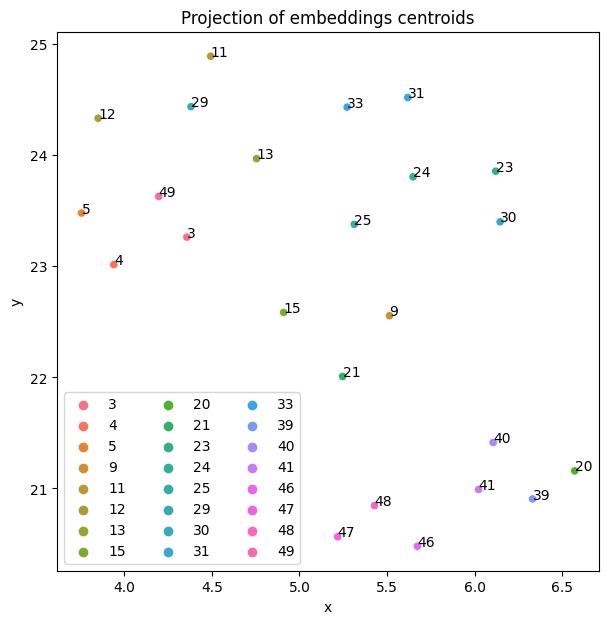

In [30]:
fig,axs = plt.subplots(1,1,figsize=(7,7))
sns.scatterplot(x=centroids_projected[:,0],y=centroids_projected[:,1],ax=axs,hue=[str(a) for a in np.unique(leaf_labels)])#hue_order=sorted([str(a) for a in leaf_labels]))
#axs.set_xlabel('x')
for i, txt in enumerate(np.unique(leaf_labels)):
    axs.annotate(str(txt),(centroids_projected[i,0],centroids_projected[i,1]))

axs.set_xlabel('x')
axs.set_ylabel('y')

plt.title('Projection of embeddings centroids')
plt.legend(loc='lower left',ncol=3)
plt.show()

# Results

In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv(Path(r"C:\Users\fadel\OneDrive\Bureau\PDM\results\confMat_customArch2_mcloss_qu15spo9.csv"))
label_names = pd.read_csv("../data/labelnames.csv",sep=';')

for col in ['Actual','Predicted']:
    mask = df[col] == 'other vegetated areas'
    df.loc[mask,col] = 'other non vegetated areas'

df_pivot = df.pivot(index='Actual',columns='Predicted',values='nPredictions')
for col in df_pivot.columns:
    df_pivot.loc[col] = np.round(df_pivot.loc[col]/df_pivot.loc[col].sum(),3)

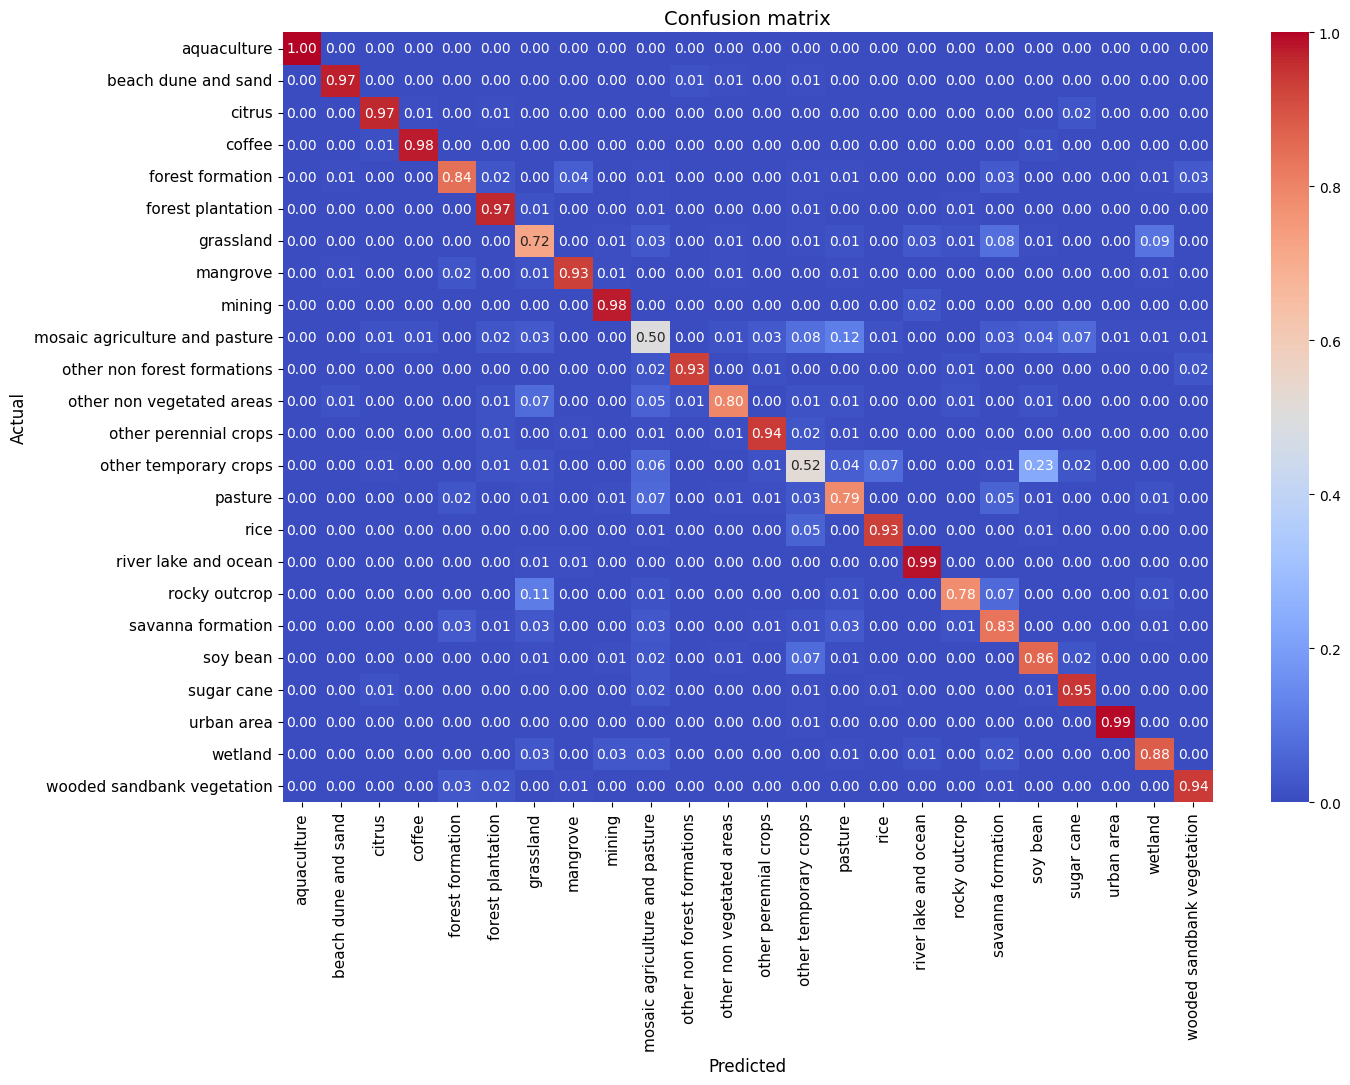

In [5]:
fig,axs = plt.subplots(1,1,figsize=(15,10))
sns.heatmap(data=df_pivot,ax=axs,annot=True,cmap='coolwarm',fmt=".2f")
axs.set_ylabel('Actual',fontsize=12)
axs.set_xlabel('Predicted',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.title('Confusion matrix',fontsize=14)
plt.show()

In [ ]:
df_best = pd.read_csv(Path(r"C:\Users\fadel\OneDrive\Bureau\PDM\results\PerClassMetrics_test_customArch2_mcloss_qu15spo9.csv"))
df_baseline = pd.read_csv(Path(r"C:\Users\fadel\OneDrive\Bureau\PDM\results\PerClassMetrics_test_leaflabels_4wjmlldk.csv"))

df_baseline['model'] = 'baseline'
df_best['model'] = 'best'

dfs = pd.concat([df_best,df_baseline],axis=0)
dfs.loc[dfs['label_name'] == 'other vegetated areas','label_name'] = 'other non vegetated areas' 

fig,axs = plt.subplots(1,1,figsize=(10,10),sharey=True,sharex=True)

sns.barplot(data=dfs,y='label_name',x='f1_score',hue='model',ax=axs)
axs.set_ylabel("Label names",fontsize=13)
axs.set_xlabel("F1 score",fontsize=13)

plt.legend()
plt.title("F1 scores of leaf labels",fontsize=14)
plt.show()

# Random forest on embeddings from Tree-triplet

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import RidgeClassifierCV

In [8]:
df_train = pd.read_csv("./embeddings_train.csv",index_col=0)
X_train = df_train.iloc[:,:-1].to_numpy()
y_train = df_train.iloc[:,-1].to_numpy()

df_test = pd.read_csv("./embeddings_test.csv",index_col=0)
X_test = df_test.iloc[:,:-1].to_numpy()
y_test = df_test.iloc[:,-1].to_numpy()

In [12]:
learner = RandomForestClassifier(max_depth=10, criterion='entropy',min_samples_split=2, random_state=41)
learner.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, random_state=41)

In [19]:
learner_ridge = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
y_pred_ridge = learner_ridge.predict(X_test)
print(classification_report(y_test,y_pred_ridge))

              precision    recall  f1-score   support

           3       0.04      0.04      0.04       150
           4       0.01      0.01      0.01       150
           5       0.09      0.07      0.08       150
           9       0.07      0.05      0.06       150
          11       0.03      0.05      0.04       150
          12       0.03      0.03      0.03       150
          13       0.12      0.01      0.02        87
          15       0.02      0.02      0.02       150
          20       0.03      0.03      0.03       150
          21       0.07      0.08      0.07       150
          23       0.08      0.09      0.09       150
          24       0.09      0.10      0.09       150
          25       0.05      0.01      0.02        83
          29       0.02      0.01      0.02        73
          30       0.00      0.00      0.00        88
          31       0.00      0.00      0.00        23
          33       0.04      0.05      0.05       150
          39       0.04    

In [14]:
y_pred = learner.predict(X_test)

In [16]:
# Results
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           3       0.06      0.07      0.07       150
           4       0.04      0.04      0.04       150
           5       0.03      0.03      0.03       150
           9       0.06      0.07      0.06       150
          11       0.03      0.03      0.03       150
          12       0.06      0.07      0.07       150
          13       0.00      0.00      0.00        87
          15       0.06      0.09      0.07       150
          20       0.02      0.02      0.02       150
          21       0.08      0.10      0.09       150
          23       0.07      0.07      0.07       150
          24       0.11      0.13      0.12       150
          25       0.00      0.00      0.00        83
          29       0.00      0.00      0.00        73
          30       0.00      0.00      0.00        88
          31       0.00      0.00      0.00        23
          33       0.03      0.03      0.03       150
          39       0.04    